In [41]:
import json
import subprocess
import sys

def ensure_package(package_name: str, install_name: str | None = None) -> None:
    """Install the pip package if it is missing from the current environment."""
    install_name = install_name or package_name
    result = subprocess.run(
        [sys.executable, "-m", "pip", "list", "--format=json"],
        check=True,
        capture_output=True,
        text=True,
    )
    installed = {pkg["name"].lower() for pkg in json.loads(result.stdout)}
    if package_name.lower() in installed:
        print(f"{package_name} already installed.")
        return
    subprocess.check_call([sys.executable, "-m", "pip", "install", install_name])
    print(f"Installed {install_name} as {package_name}.")

for package in [
    ("numpy", None),
    ("pandas", None),
    ("scikit-learn", "scikit-learn"),
    ("matplotlib", None),
    ("rdkit", "rdkit"),
    ("lightgbm", "lightgbm"),
    ("seaborn", None),
    ("shap", None)
]:
    ensure_package(*package)


numpy already installed.
pandas already installed.
scikit-learn already installed.
scikit-learn already installed.
matplotlib already installed.
matplotlib already installed.
rdkit already installed.
rdkit already installed.
lightgbm already installed.
seaborn already installed.
lightgbm already installed.
seaborn already installed.
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.1 MB ? eta -:--:--Collecting llvmlite<0.46,>=0.45.0dev0 (from numba>=0.54->shap)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.8 MB ? eta -:--:--Downloading slicer-0.0.8

In [42]:
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

In [43]:
data_path = Path("result/data/melting_point_features.csv")
if not data_path.exists():
    raise FileNotFoundError(f"Data file not found at {data_path.resolve()}")
train_data = pd.read_csv(data_path)

## Data Loading & Overview
Quick sanity checks on shape, columns, and target presence before any preprocessing.

In [44]:
# Basic shape and column overview
print("Data shape (rows, cols):", train_data.shape)
print("Columns (first 20):", list(train_data.columns[:20]))
print("Target present?", "Tm" in train_data.columns)
display(train_data.head())
display(train_data.info())

Data shape (rows, cols): (2662, 101)
Columns (first 20): ['id', 'num_atoms', 'num_heavy_atoms', 'num_hydrogens', 'num_heteroatoms', 'num_valence_electrons', 'num_rings', 'aromatic_ring_count', 'aliphatic_ring_count', 'largest_ring_size', 'num_ring_systems', 'num_fused_rings', 'num_spiro_atoms', 'has_aromatic_ring', 'has_phenyl_group', 'num_double_bonds', 'num_triple_bonds', 'num_conjugated_bonds', 'saturation_index', 'num_rotatable_bonds']
Target present? True


,id,num_atoms,num_heavy_atoms,num_hydrogens,num_heteroatoms,num_valence_electrons,num_rings,aromatic_ring_count,aliphatic_ring_count,largest_ring_size,...,hbond_donor_density,hbond_acceptor_density,surface_area_to_volume_ratio,polarity_to_size_ratio,rigidity_index,planarity_proxy_index,num_aromatic_rings_fragments,num_heteroatom_fragments,num_hbonding_fragments,Tm
0,2175,10,10,0,6,58,1,0,1,4,...,0.000000,0.000000,NaN,0.000000,1.0,0.461548,0,1,0,213.15
1,1222,17,17,11,1,69,4,4,0,6,...,0.058824,0.058824,NaN,0.072674,4.0,0.000016,4,1,1,407.15
2,2994,12,12,12,2,50,2,2,0,6,...,0.000000,0.166667,NaN,0.111222,1.0,0.505454,2,1,1,324.15
3,1704,6,6,4,2,28,0,0,0,0,...,0.166667,0.333333,NaN,0.443657,0.0,0.203662,0,1,1,351.15
4,2526,7,7,14,1,30,0,0,0,0,...,0.000000,0.000000,NaN,0.000000,0.0,0.574289,0,1,0,126.15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Columns: 101 entries, id to Tm
dtypes: float64(37), int64(60), object(4)
memory usage: 2.1+ MB


None

## Missingness and Column Types
Check missing values, non-numeric columns, and columns slated for dropping.

In [45]:
# Missingness summary and non-numeric columns
null_frac = train_data.isna().mean().sort_values(ascending=False)
print("Top 20 columns by missingness (%):")
display((null_frac.head(20) * 100).round(2))
object_cols = train_data.select_dtypes(include=["object"]).columns.tolist()
print(f"Object columns (first 20 of {len(object_cols)}):", object_cols[:20])
planned_drops = ["id", "gasteiger_charges", "principal_moments_3d", "morgan_fingerprint_bits", "maccs_keys_bits"]
present_planned_drops = [c for c in planned_drops if c in train_data.columns]
print("Planned drop columns present:", present_planned_drops)
dup_ids = train_data.duplicated(subset=["id"]).sum() if "id" in train_data.columns else 0
print(f"Duplicate ids: {dup_ids}")

Top 20 columns by missingness (%):


volume_3d                       100.00
surface_area_to_volume_ratio    100.00
surface_area_3d                   0.08
conformer_count                   0.08
radius_of_gyration_3d             0.08
eccentricity_3d                   0.08
planarity_proxy_index             0.08
inertia_mass_3d                   0.08
principal_moments_3d              0.08
dipole_proxy_spread_3d            0.08
inertial_shape_factor_3d          0.08
dipole_proxy_range_3d             0.08
asphericity_3d                    0.08
num_valence_electrons             0.00
num_rings                         0.00
aromatic_ring_count               0.00
num_triple_bonds                  0.00
num_conjugated_bonds              0.00
saturation_index                  0.00
num_rotatable_bonds               0.00
dtype: float64

Object columns (first 20 of 4): ['gasteiger_charges', 'principal_moments_3d', 'morgan_fingerprint_bits', 'maccs_keys_bits']
Planned drop columns present: ['id', 'gasteiger_charges', 'principal_moments_3d', 'morgan_fingerprint_bits', 'maccs_keys_bits']
Duplicate ids: 0


## Descriptive Statistics & Target Analysis
Summaries, distribution, and outlier check for the target and numeric features.

Numeric columns: 97 of 101 total


,count,mean,std,min,25%,50%,75%,max
id,2662.0,1652.887303,955.005512,1.0,830.25,1642.500000,2469.750000,3328.0
num_atoms,2662.0,10.201728,4.553357,2.0,7.00,10.000000,12.000000,57.0
num_heavy_atoms,2662.0,10.201728,4.553357,2.0,7.00,10.000000,12.000000,57.0
num_hydrogens,2662.0,11.822314,8.692953,0.0,7.00,10.000000,14.000000,98.0
num_heteroatoms,2662.0,2.020285,1.837325,0.0,1.00,2.000000,3.000000,21.0
num_valence_electrons,2662.0,45.099549,19.403435,9.0,32.00,42.000000,53.000000,240.0
num_rings,2662.0,0.793764,0.854235,0.0,0.00,1.000000,1.000000,7.0
aromatic_ring_count,2662.0,0.619083,0.791193,0.0,0.00,0.000000,1.000000,7.0
aliphatic_ring_count,2662.0,0.174681,0.489565,0.0,0.00,0.000000,0.000000,5.0
largest_ring_size,2662.0,3.404959,2.946310,0.0,0.00,6.000000,6.000000,17.0


count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64
IQR outlier count: 48
Skewness: 0.904
IQR outlier count: 48
Skewness: 0.904


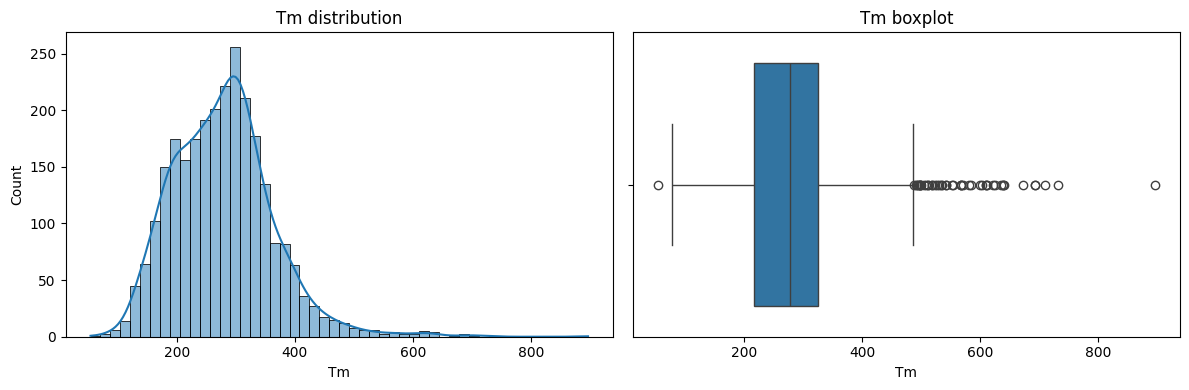

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = train_data.select_dtypes(include="number").columns.tolist()
print(f"Numeric columns: {len(numeric_cols)} of {train_data.shape[1]} total")
display(train_data[numeric_cols].describe().T.head(20))
target = train_data["Tm"]
print(target.describe())
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(target, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Tm distribution")
sns.boxplot(x=target, ax=axes[1])
axes[1].set_title("Tm boxplot")
plt.tight_layout()
q1, q3 = target.quantile([0.25, 0.75])
iqr = q3 - q1
outliers = ((target < q1 - 1.5 * iqr) | (target > q3 + 1.5 * iqr)).sum()
print(f"IQR outlier count: {outliers}")
print(f"Skewness: {target.skew():.3f}")

## Feature Distributions & Univariate Checks
Variance, skewness, and quick histograms for top correlated features.

Numeric feature count (excluding Tm): 96
Top 10 features by variance:


inertia_mass_3d           2.749189e+07
id                        9.120355e+05
topological_complexity    2.340953e+04
molecular_weight          4.810814e+03
exact_molecular_weight    4.773257e+03
surface_area_3d           1.242033e+03
tpsa                      3.857182e+02
num_valence_electrons     3.764933e+02
num_hydrogens             7.556744e+01
num_conjugated_bonds      2.571910e+01
dtype: float64

Dropping 5 constant features (variance=0): ['num_spiro_atoms', 'num_fused_rings', 'formal_charge', 'num_defined_stereo_centers', 'conformer_count']...
Top 10 most positively skewed features:


inertial_shape_factor_3d    27.010285
num_sulfonyl_groups         14.215820
has_sulfonyl                11.716106
num_thiols                  10.865216
inertia_mass_3d              9.848024
num_iodine_atoms             9.297538
has_thiol                    9.265067
num_fluorine_atoms           8.640908
num_bromine_atoms            8.002198
num_amides                   7.784165
dtype: float64

Top 10 most negatively skewed features:


conformer_count                 0.000000
num_defined_stereo_centers      0.000000
gasteiger_charge_range         -0.057871
degree_of_branchedness         -0.179514
largest_ring_size              -0.220209
num_hbonding_fragments         -0.674276
num_heteroatom_fragments       -1.770637
eccentricity_3d                -4.777421
volume_3d                            NaN
surface_area_to_volume_ratio         NaN
dtype: float64

Top 10 abs correlations with Tm:


/home/tp_ubuntu/colab/project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tp_ubuntu/colab/project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


topological_complexity          0.576550
num_conjugated_bonds            0.532366
num_atoms                       0.494154
num_heavy_atoms                 0.494154
num_valence_electrons           0.484597
num_rings                       0.477688
num_ring_systems                0.477688
aromatic_ring_count             0.476362
num_aromatic_rings_fragments    0.476362
dipole_proxy_spread_3d          0.462441
dtype: float64

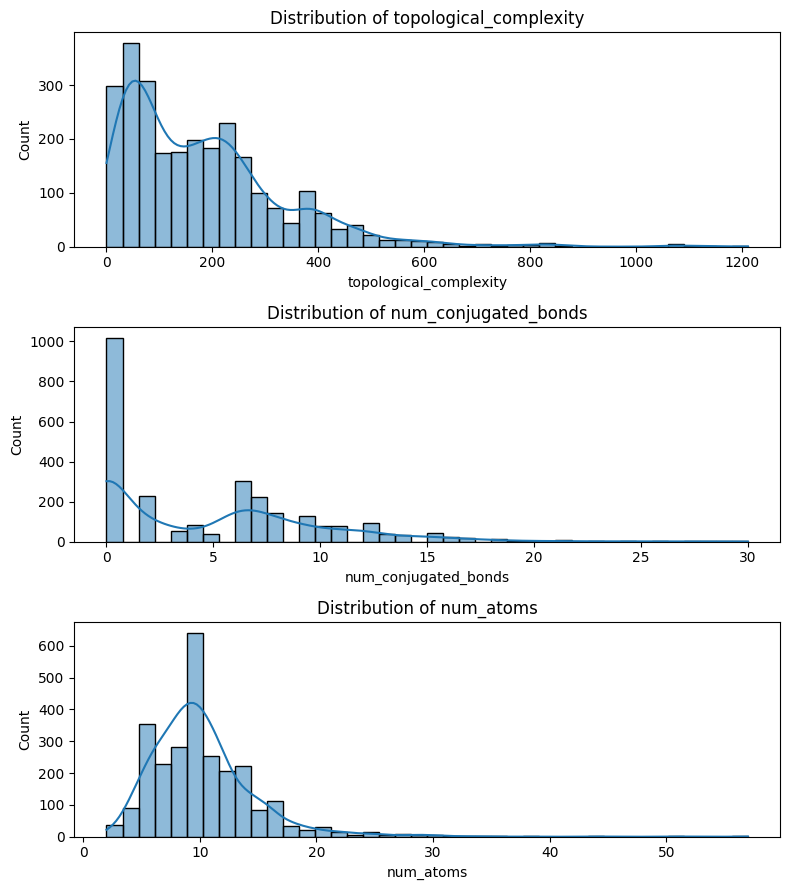

In [47]:
numeric_features = train_data.select_dtypes(include="number").drop(columns=["Tm"], errors="ignore")
print(f"Numeric feature count (excluding Tm): {numeric_features.shape[1]}")
variance = numeric_features.var().sort_values(ascending=False)
print("Top 10 features by variance:")
display(variance.head(10))
constant_cols = variance[variance == 0].index.tolist()
if constant_cols:
    print(f"Dropping {len(constant_cols)} constant features (variance=0): {constant_cols[:5]}...")
skewness = numeric_features.skew(numeric_only=True).sort_values(ascending=False)
print("Top 10 most positively skewed features:")
display(skewness.head(10))
print("Top 10 most negatively skewed features:")
display(skewness.tail(10))
corr_with_target = numeric_features.corrwith(train_data["Tm"]).abs().sort_values(ascending=False)
print("Top 10 abs correlations with Tm:")
display(corr_with_target.head(10))
top_plot_cols = corr_with_target.head(3).index.tolist()
fig, axes = plt.subplots(len(top_plot_cols), 1, figsize=(8, 3 * len(top_plot_cols)))
if len(top_plot_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, top_plot_cols):
    sns.histplot(train_data[col], bins=40, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
plt.tight_layout()

## Bivariate / Correlation Analysis
Correlations with target and among features to spot redundancy.

/home/tp_ubuntu/colab/project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tp_ubuntu/colab/project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


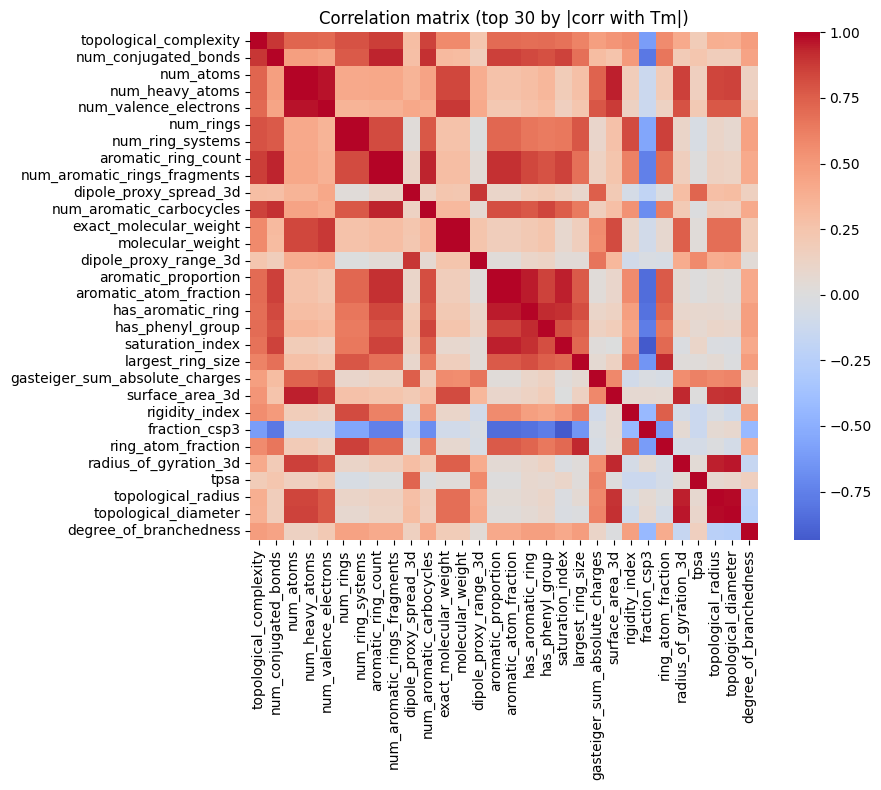

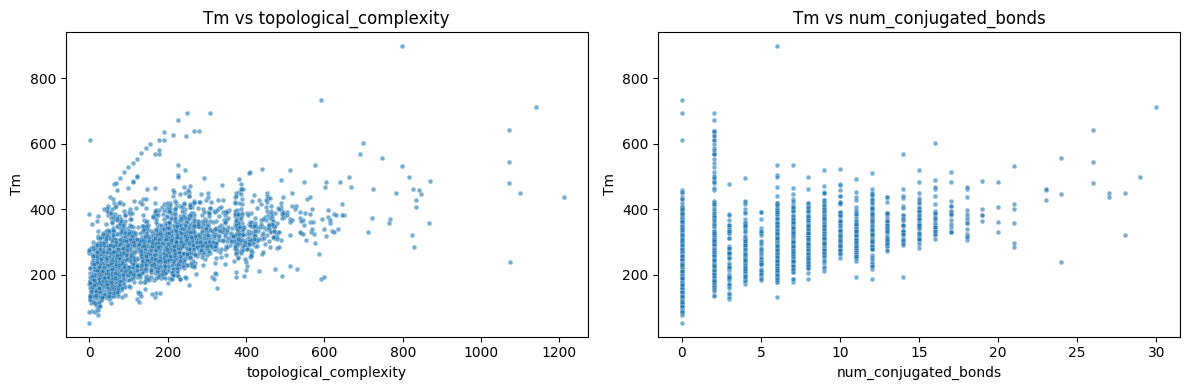

In [48]:
corr_with_target = numeric_features.corrwith(train_data["Tm"]).abs().sort_values(ascending=False)
top_corr_cols = corr_with_target.head(30).index.tolist()
plt.figure(figsize=(10, 8))
corr_matrix = numeric_features[top_corr_cols].corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True)
plt.title("Correlation matrix (top 30 by |corr with Tm|)")
plt.tight_layout()
top_scatter_cols = corr_with_target.head(2).index.tolist()
fig, axes = plt.subplots(1, len(top_scatter_cols), figsize=(12, 4))
if len(top_scatter_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, top_scatter_cols):
    sns.scatterplot(x=train_data[col], y=train_data["Tm"], s=12, alpha=0.6, ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel("Tm")
    ax.set_title(f"Tm vs {col}")
plt.tight_layout()

## Pattern Finding (PCA)
Low-dimensional view to spot clusters/outliers. Uses a sample for speed.

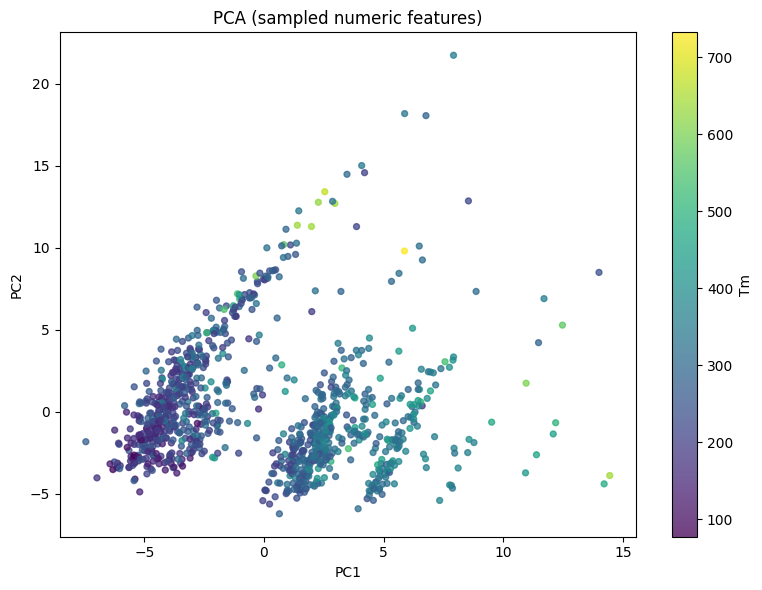

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop all-NaN columns to avoid missing medians
pca_features = numeric_features.dropna(axis=1, how="all")
sample_n = min(1000, pca_features.shape[0])
pca_sample = pca_features.sample(n=sample_n, random_state=42).copy()
col_medians = pca_sample.median(numeric_only=True)
pca_sample_filled = pca_sample.fillna(col_medians).fillna(0)
pca_target = train_data.loc[pca_sample_filled.index, "Tm"]
scaled = StandardScaler().fit_transform(pca_sample_filled)
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(scaled)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pcs[:, 0], pcs[:, 1], c=pca_target, cmap="viridis", s=18, alpha=0.75)
plt.colorbar(scatter, label="Tm")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (sampled numeric features)")
plt.tight_layout()

## Data Cleaning Decisions
Document what to drop or transform before modeling.

In [50]:
log_transform_candidates = (skewness[skewness > 1].index.tolist() if "skewness" in locals() else [])
drop_constant_list = constant_cols if "constant_cols" in locals() else []
fp_cols = [c for c in ["morgan_fingerprint_bits", "maccs_keys_bits"] if c in train_data.columns]
fp_one_counts = {}
for fp_col in fp_cols:
    fp_one_counts[fp_col] = train_data[fp_col].astype(str).str.count("1").describe().to_dict()
clean_config = {
    "planned_drop": present_planned_drops if "present_planned_drops" in locals() else [],
    "drop_constant": drop_constant_list,
    "impute_strategy": "median for numeric",
    "log_transform_candidates": log_transform_candidates,
    "winsorize": {"lower_quantile": 0.01, "upper_quantile": 0.99},
    "fingerprint_one_counts": fp_one_counts,
}
print(json.dumps(clean_config, indent=2))
if fp_one_counts:
    print("Fingerprint bitcount summaries:")
    display(pd.DataFrame(fp_one_counts))

{
  "planned_drop": [
    "id",
    "gasteiger_charges",
    "principal_moments_3d",
    "morgan_fingerprint_bits",
    "maccs_keys_bits"
  ],
  "drop_constant": [
    "num_spiro_atoms",
    "num_fused_rings",
    "formal_charge",
    "num_defined_stereo_centers",
    "conformer_count"
  ],
  "impute_strategy": "median for numeric",
  "log_transform_candidates": [
    "inertial_shape_factor_3d",
    "num_sulfonyl_groups",
    "has_sulfonyl",
    "num_thiols",
    "inertia_mass_3d",
    "num_iodine_atoms",
    "has_thiol",
    "num_fluorine_atoms",
    "num_bromine_atoms",
    "num_amides",
    "has_amide",
    "num_triple_bonds",
    "num_positive_atoms",
    "num_strong_hbond_acceptors",
    "num_negative_atoms",
    "num_nitro_groups",
    "num_stereo_centers",
    "num_undefined_stereo_centers",
    "num_carboxylic_acids",
    "has_nitro",
    "is_zwitterionic",
    "hbond_donor_density",
    "has_carboxylic_acid",
    "num_alcohols",
    "num_halogen_atoms",
    "num_rotatable_bond

,morgan_fingerprint_bits,maccs_keys_bits
count,2662.000000,2662.000000
mean,15.462810,15.192712
std,5.763138,7.163368
min,2.000000,1.000000
25%,11.000000,10.000000
50%,15.000000,14.000000
75%,19.000000,19.000000
max,49.000000,56.000000


In [51]:
TARGET_COLUMN = "Tm"
drop_columns = [
    "id",
    "gasteiger_charges",
    "principal_moments_3d",
    "morgan_fingerprint_bits",
    "maccs_keys_bits",
]
existing_drop = [col for col in drop_columns if col in train_data.columns]
clean_data = train_data.drop(columns=existing_drop)
if TARGET_COLUMN not in clean_data.columns:
    raise KeyError(f"'{TARGET_COLUMN}' column missing from dataset")
feature_frame = clean_data.drop(columns=[TARGET_COLUMN]).apply(pd.to_numeric, errors="coerce")
all_nan_cols = feature_frame.columns[feature_frame.isna().all()]
if len(all_nan_cols) > 0:
    print(f"Dropping {len(all_nan_cols)} columns with only NaN values: {list(all_nan_cols)[:5]}...")
    feature_frame = feature_frame.drop(columns=all_nan_cols)
median_values = feature_frame.median(numeric_only=True)
X = feature_frame.fillna(median_values).astype(np.float32)
y = clean_data[TARGET_COLUMN].astype(np.float32)
print(f"Selected {X.shape[1]} features across {X.shape[0]} samples.")
print(f"Target distribution — mean: {y.mean():.2f}, std: {y.std():.2f}")

Dropping 2 columns with only NaN values: ['volume_3d', 'surface_area_to_volume_ratio']...
Selected 93 features across 2662 samples.
Target distribution — mean: 278.26, std: 85.12


In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
 )
model = lgb.LGBMRegressor(
    objective="regression",
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
 )
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric="l1",
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(30)],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6007
[LightGBM] [Info] Number of data points in the train set: 2129, number of used features: 86
[LightGBM] [Info] Start training from score 277.791617
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
[50]	training's l1: 26.861	training's l2: 1449.86	valid_1's l1: 34.297	valid_1's l2: 2434.1
[50]	training's l1: 26.861	training's l2: 1449.86	valid_1's l1: 34.297	valid_1's l2: 2434.1
[100]	training's l1: 20.389	training's l2: 854.687	valid_1's l1: 31.3632	valid_1's l2: 2060.34
[100]	training's l1: 20.389	training's l2: 854.687	valid_1's l1: 31.3632	valid_1's l2: 2060.34
[150]	training's l1: 17.2761	training's l2: 615.348	valid_1's l1: 30.7043	valid_1's l2: 1982.25
[

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
y_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)
print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R^2: {r2:.3f}")
validation_results = (
    pd.DataFrame({
        "sample_index": y_valid.index,
        "true_Tm": y_valid.values,
        "predicted_Tm": y_pred,
        "abs_error": np.abs(y_valid.values - y_pred),
    })
    .sort_values("abs_error", ascending=False)
    .reset_index(drop=True)
 )
output_dir = Path("result/data")
output_dir.mkdir(parents=True, exist_ok=True)
prediction_path = output_dir / "baseline_lgbm_predictions.csv"
metrics_path = output_dir / "baseline_lgbm_metrics.json"
validation_results.to_csv(prediction_path, index=False)
metrics_payload = {
    "mae": float(mae),
    "rmse": float(rmse),
    "r2": float(r2),
    "n_train": int(len(y_train)),
    "n_valid": int(len(y_valid)),
}
metrics_path.write_text(json.dumps(metrics_payload, indent=2))
importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)
print(f"Saved validation predictions to {prediction_path}.")
print(f"Saved metrics to {metrics_path}.")
top_features

Validation MAE: 30.55 K
Validation RMSE: 44.37 K
Validation R^2: 0.737
Saved validation predictions to result/data/baseline_lgbm_predictions.csv.
Saved metrics to result/data/baseline_lgbm_metrics.json.


gasteiger_max_partial_charge      268
planarity_proxy_index             252
asphericity_3d                    242
gasteiger_sum_absolute_charges    230
topological_complexity            225
dipole_proxy_spread_3d            220
molecular_weight                  199
gasteiger_min_partial_charge      194
inertial_shape_factor_3d          193
logp                              192
dtype: int32

## Post-model Explainability
Inspect feature importance and (optionally) SHAP for the LightGBM model.

/home/tp_ubuntu/colab/project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


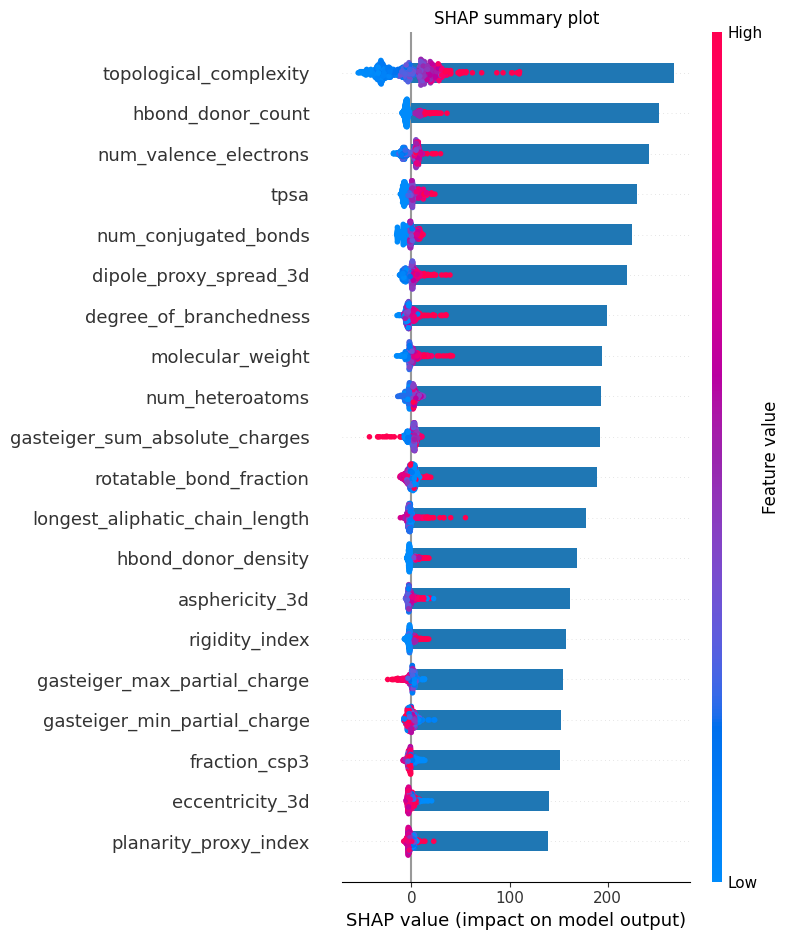

In [54]:
# Feature importance bar plot
importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_importances = importances.sort_values(ascending=False).head(20)
plt.figure(figsize=(8, 6))
top_importances.sort_values().plot(kind="barh")
plt.title("Top 20 Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.tight_layout()

# Optional SHAP summary (skip if shap missing)
try:
    import shap
    shap_explainer = shap.TreeExplainer(model)
    shap_values = shap_explainer.shap_values(X_valid)
    shap.summary_plot(shap_values, X_valid, show=False)
    plt.title("SHAP summary plot")
    plt.tight_layout()
except ImportError:
    print("Install shap to view SHAP plots: pip install shap")

## SHAP Top-20 Feature Model
Train a compact model using the 20 most important SHAP features and compare to the baseline.

In [55]:
import numpy as np
from pathlib import Path


# Compute mean absolute SHAP importance
if isinstance(shap_values, list):
    shap_array = np.array(shap_values[0])
else:
    shap_array = np.array(shap_values)
shap_mean_abs = np.abs(shap_array).mean(axis=0)
feature_names = np.array(X_train.columns)
top20_idx = np.argsort(shap_mean_abs)[::-1][:20]
top20_features = feature_names[top20_idx]
print("Top 20 features by mean |SHAP|:")
print(top20_features)

# Prepare top-20 datasets
X_train_top = X_train[top20_features]
X_valid_top = X_valid[top20_features]

# Train new model on top-20 features
baseline_metrics = {"mae": float(mae), "rmse": float(rmse), "r2": float(r2)}
model_top = lgb.LGBMRegressor(
    objective="regression",
    random_state=42,
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
 )
model_top.fit(
    X_train_top,
    y_train,
    eval_set=[(X_train_top, y_train), (X_valid_top, y_valid)],
    eval_metric="l1",
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(30)],
 )

# Evaluate
y_pred_top = model_top.predict(X_valid_top)
mae_top = mean_absolute_error(y_valid, y_pred_top)
rmse_top = np.sqrt(mean_squared_error(y_valid, y_pred_top))
r2_top = r2_score(y_valid, y_pred_top)
top_metrics = {"mae": float(mae_top), "rmse": float(rmse_top), "r2": float(r2_top)}
print("\nBaseline metrics:", baseline_metrics)
print("Top-20 metrics:", top_metrics)
comparison = pd.DataFrame([baseline_metrics, top_metrics], index=["baseline_all_features", "shap_top20"])
display(comparison)

# Save comparison
output_dir = Path("result/data")
output_dir.mkdir(parents=True, exist_ok=True)
top_metrics_path = output_dir / "shap_top20_metrics.json"
comparison_path = output_dir / "baseline_vs_shap_top20_metrics.csv"
top_metrics_path.write_text(json.dumps(top_metrics, indent=2))
comparison.to_csv(comparison_path)
print(f"Saved top-20 metrics to {top_metrics_path}")
print(f"Saved comparison table to {comparison_path}")

Top 20 features by mean |SHAP|:
['topological_complexity' 'hbond_donor_count' 'num_valence_electrons'
 'tpsa' 'num_conjugated_bonds' 'dipole_proxy_spread_3d'
 'degree_of_branchedness' 'molecular_weight' 'num_heteroatoms'
 'gasteiger_sum_absolute_charges' 'rotatable_bond_fraction'
 'longest_aliphatic_chain_length' 'hbond_donor_density' 'asphericity_3d'
 'rigidity_index' 'gasteiger_max_partial_charge'
 'gasteiger_min_partial_charge' 'fraction_csp3' 'eccentricity_3d'
 'planarity_proxy_index']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 2129, number of used features: 20
[LightGBM] [Info] Start training from score 277.791617
Training until validation scores don't improve for 30 rounds
[50]	training's l1: 27.9255	training'

,mae,rmse,r2
baseline_all_features,30.545636,44.371628,0.737392
shap_top20,30.122204,45.424313,0.724784


Saved top-20 metrics to result/data/shap_top20_metrics.json
Saved comparison table to result/data/baseline_vs_shap_top20_metrics.csv
